# Dataset Overview

In this project we review the _Airplaine Passenger Satisfaction_ dataset found on kaggle.com (https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction). This dataset contains survey information for passengers who recently took a flight with an airline company. The survey questions range take into account their entire experience, from their initial booking all the way through their inflight experience. Understanding which customers are satisfied with their service can lead to targeted promotions and marketing that may be more successful than cold marketing.
  
The dataset is in tabular form, with ~129k oberservations, where each one represents satisfaction responses from a customer. Most numeric values are constrained in a likert scale between 0-5 where 0 represents very unsatisfied and 5 represents highly satisfied. Due to their equally spaced nature, which does not add value to a model, they will be treated as categorical features with ordinal encoding.

Furthermore, the dataset is heterogenous with a combination of numeric and categorical values totaling 25 columns.  Some other numeric values are truly numeric such as _flight distance_ which represents a continuous scale. All other categorical values are nominal where no inherent order is specified. Lastly, the target variable is binary, which identifies if the customer was satisfied with the service or not.

# 1. Import Libraries and Load Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder#, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy import stats
import six
from scipy.stats import randint
from imblearn.over_sampling import SMOTE
from collections import Counter
from tqdm import tqdm

pd.set_option('display.max_columns', None)
seed =40

In [2]:
df_test = pd.read_csv(r"data/archive/test.csv")
df_train = pd.read_csv(r"data/archive/train.csv")

#Check if all columns are the same
df_train.columns == df_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [3]:
#concat dfs into one (axis=1)
df_conc = pd.concat([df_test, df_train])

In [4]:
df_conc.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,satisfied


# 2. Check Dataset for Missing Values and Data Types

Column 'Arrival Delay in Minutes' seems to have some missing values. 393 values to be exact. Since it only represents a very small fraction of the dataset, these observatiions will be removed. An alternative approach is to use an imputation method. Simple methods can be using the average or mode value, other advanced methods include **regression imputation**. It is crucial to remove null values as many algorithms are unable to handle them.

In [5]:
df_conc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129880 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         129880 non-null  int64  
 1   id                                 129880 non-null  int64  
 2   Gender                             129880 non-null  object 
 3   Customer Type                      129880 non-null  object 
 4   Age                                129880 non-null  int64  
 5   Type of Travel                     129880 non-null  object 
 6   Class                              129880 non-null  object 
 7   Flight Distance                    129880 non-null  int64  
 8   Inflight wifi service              129880 non-null  int64  
 9   Departure/Arrival time convenient  129880 non-null  int64  
 10  Ease of Online booking             129880 non-null  int64  
 11  Gate location                      1298

In [6]:
#remove observations which have na in feature "Arrival Delay in Minutes'
df_conc = df_conc.dropna(subset=['Arrival Delay in Minutes'])

In [7]:
#df_conc.columns

In [8]:
#separate categorical columns from numerical

#define numeric columns to be scaled
numeric_columns = ['Age',
                   'Flight Distance',
                   #'Departure Delay in Minutes',
                   'Arrival Delay in Minutes'                   
                   ]

#define ordinal cat columns (should be left as-is)
cat_ord_columns = ['Inflight wifi service',
                   'Departure/Arrival time convenient', 
                   'Ease of Online booking',
                   'Gate location', 
                   'Food and drink', 
                   'Online boarding', 
                   'Seat comfort',
                   'Inflight entertainment', 
                   'On-board service', 
                   'Leg room service',
                   'Baggage handling', 
                   'Checkin service', 
                   'Inflight service',
                   'Cleanliness'
                     ]

#define nominal cat columns to be one-hot-encoded
cat_nom_columns = ['Gender',
                   'Customer Type',
                   'Type of Travel',
                   'Class'                   
                  ]

### 2a. Remove Identifier columns
Identifier columns do not add any value to algorithms. In fact, numerical values can introduce noise.

In [9]:
#identify features to remove
cols_to_remove = ['Unnamed: 0', #row identifier - index
                 'id' #unique observation identifier
                 ]
#drop columns
df_conc = df_conc.drop(columns=cols_to_remove)

### 2b. Check for Collinearity and remove features as needed
'Departure Delay in Minutes' and 'Arrival Delay in Minutes'. Due to high collinearity, the former will be removed. This is because a flight can be delayed by a few minutes and still arrive on time if the flight is cleared to fly at faster speeds. Some algorithms like Logistic Regression can be extremely sensitive to serially correlated features resulting in bias. Bias can lead to underfitting of the data.

In [10]:
X = add_constant(df_conc[numeric_columns]) #remove target variable

# Create a DataFrame that will hold the feature names and their VIFs
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns

# Calculate VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

                    Feature       VIF
0                     const  8.859531
1                       Age  1.010198
2           Flight Distance  1.010074
3  Arrival Delay in Minutes  1.000127


In [11]:
df_conc = df_conc.drop(columns=['Departure Delay in Minutes'])

### 2c. Checking Target Variable
Some algorithms are also sensitive to class imbalance. The majority class can introduce some bias. Some class imbalance was found. Not extreme, but it will be corrected in section 3.

In [12]:
#Identify target column cardinality.
print(f"The target values are: {df_conc['satisfaction'].unique()}\n")

print(f"The counts of each target is:\n{df_conc['satisfaction'].value_counts()}")

The target values are: ['satisfied' 'neutral or dissatisfied']

The counts of each target is:
neutral or dissatisfied    73225
satisfied                  56262
Name: satisfaction, dtype: int64


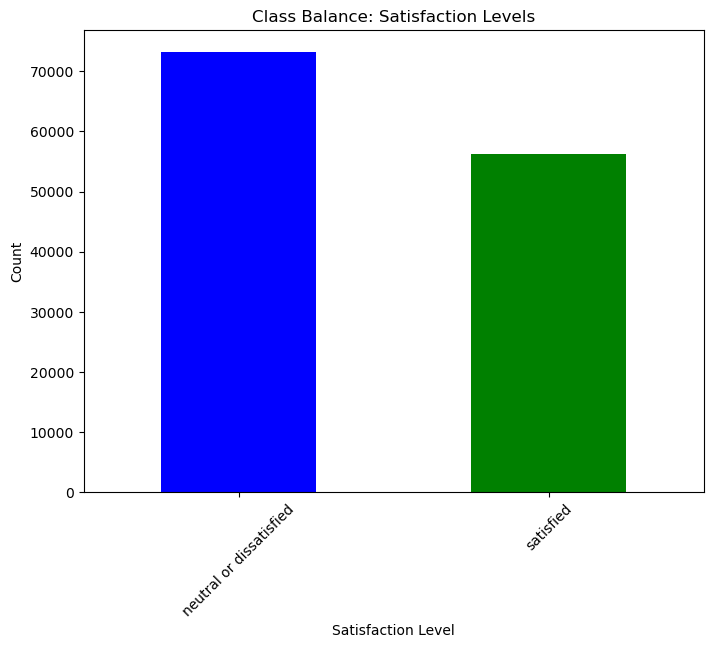

In [13]:
plt.figure(figsize=(8, 6))
df_conc['satisfaction'].value_counts().plot(kind='bar', color=['blue', 'green'])
plt.xlabel('Satisfaction Level')
plt.ylabel('Count')
plt.title('Class Balance: Satisfaction Levels')
plt.xticks(rotation=45)
plt.show()

### 2d. Encode Target Variable & Nominal Categorical Features
To enconde categorical variables we'll employ Pandas' get_dummies(). Encoding is the process of turning values into algorithhm readable characters. These characters are usually numerical. In R, the labels can remain, but the data type would need to be changed to 'factor'. Label encoder works well for the target variable. However, in nominal categorical features where there is high cardinality, it can give an algorithm the impression that there is order. To avoid this, the one-hot-encoding is used to pivot each class into its own binary feature.

In [14]:
#init LabelEncoder
label_encoder = LabelEncoder()

#fit encoder
df_conc['satisfaction'] = label_encoder.fit_transform(df_conc['satisfaction'])

In [15]:
#one-hot-encode
df_conc = pd.get_dummies(df_conc, columns=cat_nom_columns)

### 2e. Scale and Transform Numerical Features
Depart delay and departure delay have some negative values. They will not be removed as early departure could be pleasant for some customers and unpleasant for others. This sentiment may display in the likert scores.

Scaling helps to put numeric values into a limited readable range for the algorithm, whereas transformations are used to normalize the shape of the distribution.

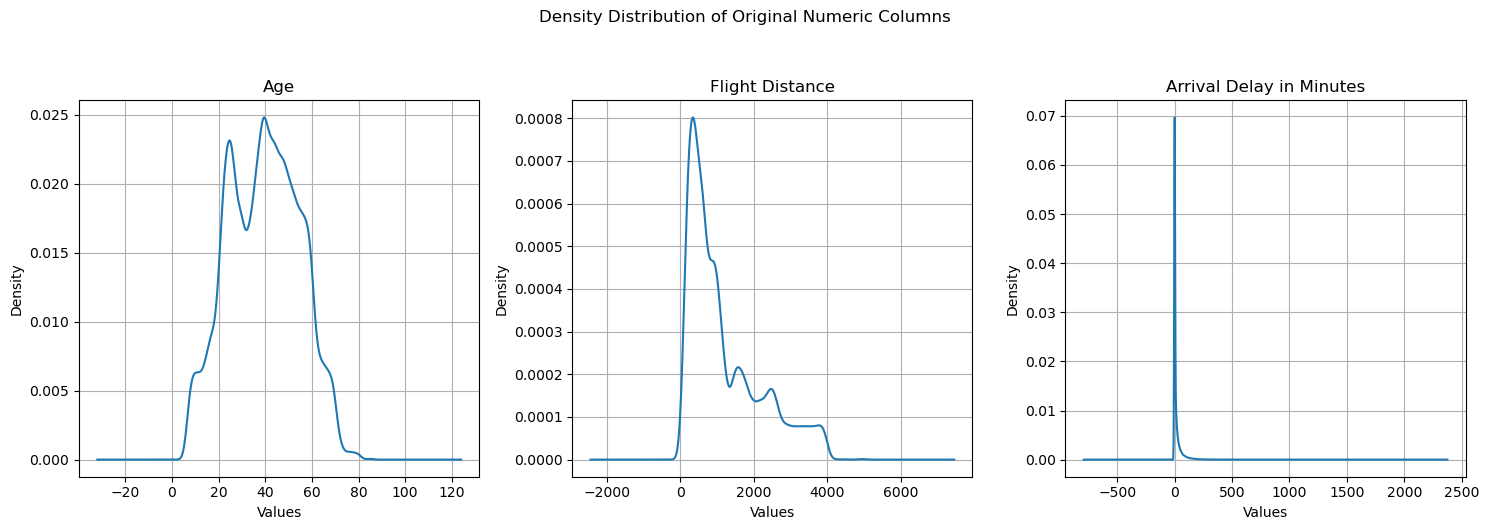

In [16]:
fig1, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig1.suptitle('Density Distribution of Original Numeric Columns', y=1.05)

for i, column in enumerate(numeric_columns):
    ax=axes[i]
    df_conc[column].plot(kind='kde', ax=ax)
    ax.set_title(column)
    ax.set_xlabel('Values')
    ax.set_ylabel('Density')
    ax.grid(True)

plt.tight_layout()
plt.show()

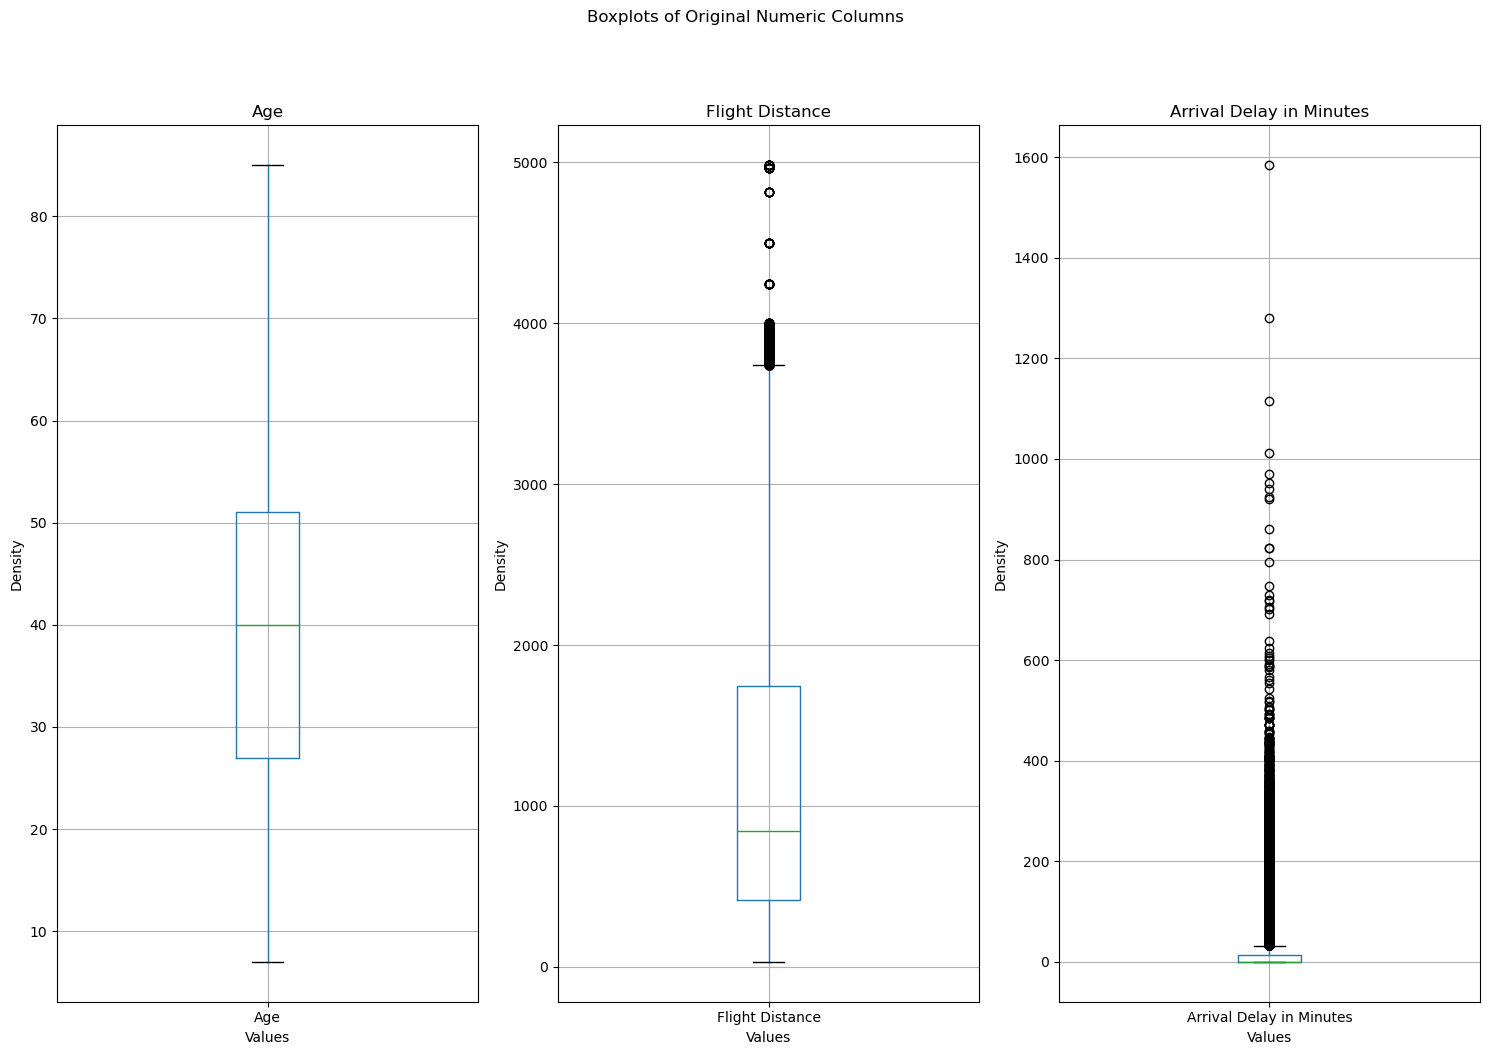

In [17]:
#plot boxplots
fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
fig2.suptitle('Boxplots of Original Numeric Columns', y=1.05)

# Plotting the boxplot for each numeric column
for i, column in enumerate(numeric_columns):
    ax = axes[i]
    df_conc.boxplot(column=column, ax=ax)
    ax.set_title(column)
    ax.set_xlabel('Values')
    ax.set_ylabel('Density')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [18]:
#### Scale Data
scaler = StandardScaler()

df_conc[numeric_columns] = scaler.fit_transform(df_conc[numeric_columns])

In [19]:
#Power Transform numeric values
transformer = PowerTransformer(method='yeo-johnson', standardize=True)

df_conc[numeric_columns] = transformer.fit_transform(df_conc[numeric_columns])
df_conc[numeric_columns] = transformer.transform(df_conc[numeric_columns])

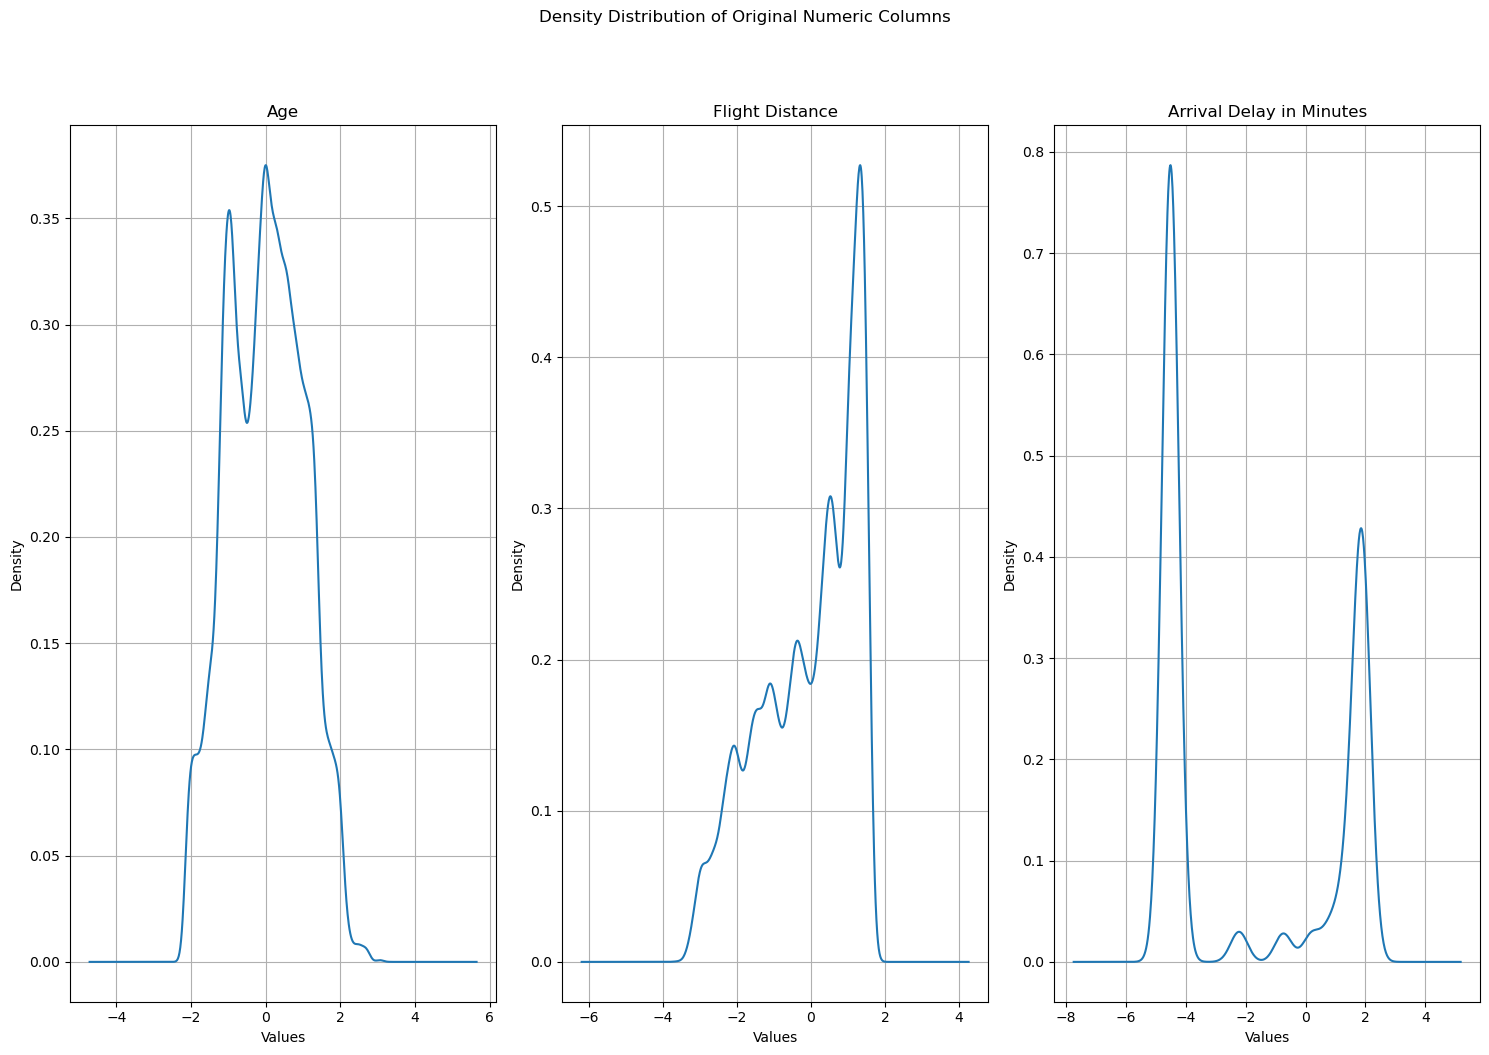

In [20]:
fig3, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
fig3.suptitle('Density Distribution of Original Numeric Columns', y=1.05)

for i, column in enumerate(numeric_columns):
    ax=axes[i]
    df_conc[column].plot(kind='kde', ax=ax)
    ax.set_title(column)
    ax.set_xlabel('Values')
    ax.set_ylabel('Density')
    ax.grid(True)

#remove empty plots in grid
# for j in range(len(numeric_columns), 2*2):
#     fig1.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

# 3. Fixing Class Imbalance & Splitting Data in Test and Train

In [21]:
#Separate Features and Target Variable
X = df_conc.drop(['satisfaction'], axis=1)
y = df_conc['satisfaction']

#Split data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

#Execute SMOTE
sm = SMOTE(random_state=seed)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("Resampled dataset shape %s" % Counter(y_train))

Resampled dataset shape Counter({0: 54916, 1: 54916})


In [22]:
#save preprocessed dataset
X_train.to_csv(r"preprocessed_data/X_train.csv")
y_train.to_csv(r"preprocessed_data/y_train.csv")
X_test.to_csv(r"preprocessed_data/X_test.csv")
y_test.to_csv(r"preprocessed_data/y_test.csv")

# 4. Initialize Scikitlearn Pipeline and Pipeline parameters
Pipeline() is a scikitlearn library used to streamline the training process. It allows a datascientist to create a systemized approach to training several machine learning models sequentially. It also allows the integration of other preprocessing steps such as standardizing values or encoding categorical labels.

In [23]:
#initialize algorithms
pipeline_logistic = Pipeline([
    ('model', LogisticRegression())
])
pipeline_svm = Pipeline([
    ('model', SVC())
])
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier())
])
pipeline_gb = Pipeline([
    ('model', GradientBoostingClassifier())
])

#initialize parameters search for each algorithm
# Define parameter grids for each model
param_grid_logistic = {
    'model__C': [0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear']
}

param_grid_svm = {
    'model__C': [0.1, 1, 10, 100],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto']
}

param_grid_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

param_grid_gb = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.8, 1.0]
}

# 5. Train Models

In [ ]:
%%time

grid_logistic = GridSearchCV(pipeline_logistic, param_grid_logistic, cv=5, scoring='accuracy', n_jobs = 4)
grid_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs = 4)
grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs = 4)
grid_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=5, scoring='accuracy', n_jobs = 4)

#fit models
grid_logistic.fit(X_train, y_train)
grid_svm.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)
grid_gb.fit(X_train, y_train)

/home/lix/miniconda3/envs/rapids/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
# Predict and evaluate each model
models = {
    'Logistic Regression': grid_logistic,
    'SVM': grid_svm,
    'Random Forest': grid_rf,
    'Gradient Boosting': grid_gb
}

In [ ]:
for name, model in models.items():
    print(f"Best parameters for {name}: {model.best_params_}")
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {name}: {accuracy:.4f}")

# 6. Evaluate Models

### 6.1 Confusion Matrices

In [ ]:
y_preds = {}
conf_matrices = {}

for name, model in models.items():
    y_preds[name] = model.predict(X_test)
    conf_matrices[name] = confusion_matrix(y_test, y_preds[name])

# Plot 2x2 grid of confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'Confusion Matrix for {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

### 6.2 ROC Curves

In [ ]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

### 6.3 Best Model Classification Report

In [ ]:
#retrain best model:
# knn_model.fit(X_train, y_train)
# y_pred = knn_model.predict(X_test)

# Compute performance metrics for best model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
f1 = report['weighted avg']['f1-score']


conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
report_df

# Results